# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_2000.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,capres mahfud md optimistis ppp parlemen tahun...,positif
1,cawapres koalisi perubahan muhaimin iskandar c...,positif
2,capres koalisi pdip ganjar pranowo khawatir su...,positif
3,capres ganjar pranowo mengaku khawatir preside...,positif
4,capres koalisi perubahan anies baswedan presid...,positif
5,capres koalisi perubahan anies baswedan mengak...,positif
6,cawapres koalisi indonesia maju kim gibran rak...,positif
7,capres koalisi perubahan anies baswedan menarg...,positif
8,capres koalisi indonesia maju prabowo subianto...,positif
9,capres koalisi perubahan anies baswedan mengun...,positif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [10]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

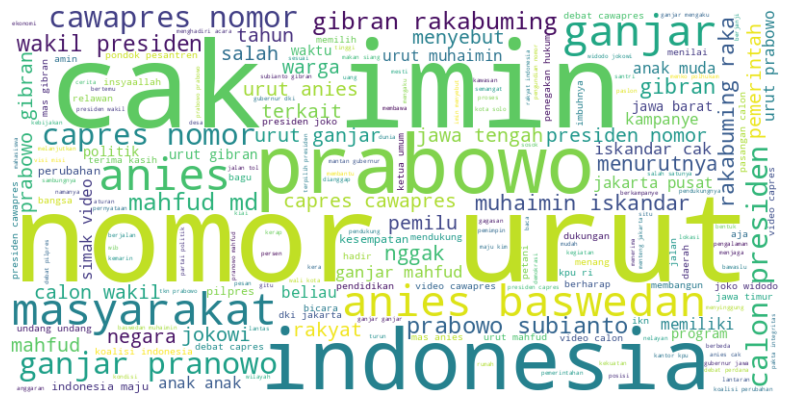

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [12]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

LSA Topics:

Topic #0:
gibran ganjar prabowo imin anies cak cak imin mahfud cawapres indonesia

Topic #1:
imin cak cak imin anies muhaimin amin iskandar muhaimin iskandar iskandar cak urut muhaimin

Topic #2:
gibran prabowo rakabuming gibran rakabuming raka rakabuming raka urut gibran anak susu cawapres

Topic #3:
prabowo anies prabowo subianto subianto indonesia baswedan anies baswedan urut prabowo koalisi capres

Topic #4:
anies ikn kota pembangunan baswedan anies baswedan urut anies nusantara pemerataan membangun

Topic #5:
debat kpu mahfud cawapres anies capres cawapres 2024 pasangan kpu ri debat cawapres

Topic #6:
ikn prabowo kota pembangunan debat nusantara jokowi mahfud pemerataan membangun kota

Topic #7:
hukum penegakan penegakan hukum mahfud indonesia anies putusan nilai mk jokowi

Topic #8:
ganjar gibran penegakan hukum penegakan jokowi capres kpu debat hukum putusan

Topic #9:
debat anak program gratis debat cawapres anak anak capres debat capres muda anak muda


In [13]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Function to generate word cloud for each topic
# def generate_wordclouds(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
#         wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.title(f"Topic #{topic_idx}")
#         plt.show()

# # Generate word clouds for LSA topics
# generate_wordclouds(lsa_model, feature_names, 10)


## Model Naiye Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [15]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [16]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 73.33333333333333
TF-IDF Vectorization F1 Score: 73.29420016232592
Bag of Words (BoW) Accuracy: 70.5
Bag of Words (BoW) F1 Score: 70.48582015886792
Combined TF-IDF and BoW Accuracy: 71.5
Combined TF-IDF and BoW F1 Score: 71.36561654079901


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 71.16666666666667
TF-IDF Vectorization F1 Score: 70.99232653078201
Bag of Words (BoW) Accuracy: 68.0
Bag of Words (BoW) F1 Score: 67.79221067617598
Combined TF-IDF and BoW Accuracy: 71.0
Combined TF-IDF and BoW F1 Score: 70.74693441039965


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.83333333333333
TF-IDF Vectorization F1 Score: 75.82333798814062
Bag of Words (BoW) Accuracy: 74.83333333333333
Bag of Words (BoW) F1 Score: 74.79525143542982
Combined TF-IDF and BoW Accuracy: 74.33333333333333
Combined TF-IDF and BoW F1 Score: 74.28608513341338


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=10, gamma=0.1, kernel='sigmoid')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.83333333333333
TF-IDF Vectorization F1 Score: 75.82333798814062
Bag of Words (BoW) Accuracy: 74.83333333333333
Bag of Words (BoW) F1 Score: 74.79525143542982
Combined TF-IDF and BoW Accuracy: 74.5
Combined TF-IDF and BoW F1 Score: 74.45960922015534


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.5
TF-IDF Vectorization F1 Score: 75.4617119740422
Bag of Words (BoW) Accuracy: 74.16666666666667
Bag of Words (BoW) F1 Score: 74.14198907399012
Combined TF-IDF and BoW Accuracy: 76.66666666666667
Combined TF-IDF and BoW F1 Score: 76.64325088174152


#### Parameter

In [23]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=1,penalty="l2",random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.5
TF-IDF Vectorization F1 Score: 75.4617119740422
Bag of Words (BoW) Accuracy: 74.16666666666667
Bag of Words (BoW) F1 Score: 74.14198907399012
Combined TF-IDF and BoW Accuracy: 76.66666666666667
Combined TF-IDF and BoW F1 Score: 76.64325088174152


## Model Random Forest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [25]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 73.33333333333333
TF-IDF Vectorization F1 Score: 73.14231919175522
Bag of Words (BoW) Accuracy: 76.5
Bag of Words (BoW) F1 Score: 76.36197520099827
Combined TF-IDF and BoW Accuracy: 75.16666666666667
Combined TF-IDF and BoW F1 Score: 75.1026558282412


#### Parameter

In [26]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_split=10,min_samples_leaf=2,n_estimators=150, random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 76.0
TF-IDF Vectorization F1 Score: 75.9552813743846
Bag of Words (BoW) Accuracy: 75.66666666666667
Bag of Words (BoW) F1 Score: 75.67918452927445
Combined TF-IDF and BoW Accuracy: 76.33333333333333
Combined TF-IDF and BoW F1 Score: 76.29007928926734


## Model Ensemble Learning

In [27]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [28]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [29]:
# Membuat model ensemble
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [30]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 77.5
TF-IDF Vectorization F1 Score: 77.45823389473668
Bag of Words (BoW) Accuracy: 76.16666666666667
Bag of Words (BoW) F1 Score: 76.05199140375909
Combined TF-IDF and BoW Accuracy: 76.83333333333333
Combined TF-IDF and BoW F1 Score: 76.76343277569319
